<a href="https://colab.research.google.com/github/naomifridman/DeepLearning_timeseries_introduction/blob/main/CNN_with_RNN_for_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [12]:
!git clone https://github.com/naomifridman/DeepLearning_timeseries_introduction

fatal: destination path 'DeepLearning_timeseries_introduction' already exists and is not an empty directory.


# CNN with LSTM

## In many cases CNN is enought
![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/ecg1.png)


# But best is to combine CNN with RNN
## - For signal preprocessing
## - For feture exctraction


# Signal classificatoin with Conv1D example
* based on: https://www.kaggle.com/code/ripcurl/time-series-classifier-keras-conv1d-lstm-dense/edit

### Load the data: the FordA dataset
The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

In [13]:

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")
y_train[y_train==-1]=0
y_test[y_test==-1] = 0
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)
x_train.shape, y_train.shape,y_test.shape,x_test.shape

((3601, 500, 1), (3601,), (1320,), (1320, 500, 1))

## Visualize some data

Here we visualize one timeseries example for each class in the dataset.

In [14]:
y_train[0:5]

array([0, 1, 0, 0, 0])

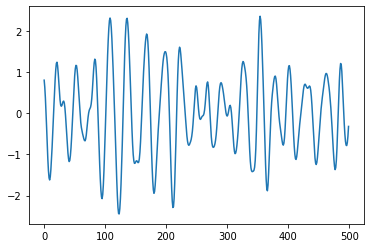

In [15]:
plt.plot(x_train[1])

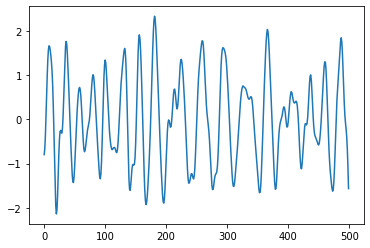

In [16]:
plt.plot(x_train[0])

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [17]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=0)

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [18]:
'''from keras.utils import to_categorical
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_test.shape'''

'from keras.utils import to_categorical\ny_train[y_train == -1] = 0\ny_test[y_test == -1] = 0\ny_train = to_categorical(y_train)\ny_test = to_categorical(y_test)\ny_train.shape, y_test.shape'

## Build a model
* 2 Conv1d layers
* 3 lstm layers
* dense layers

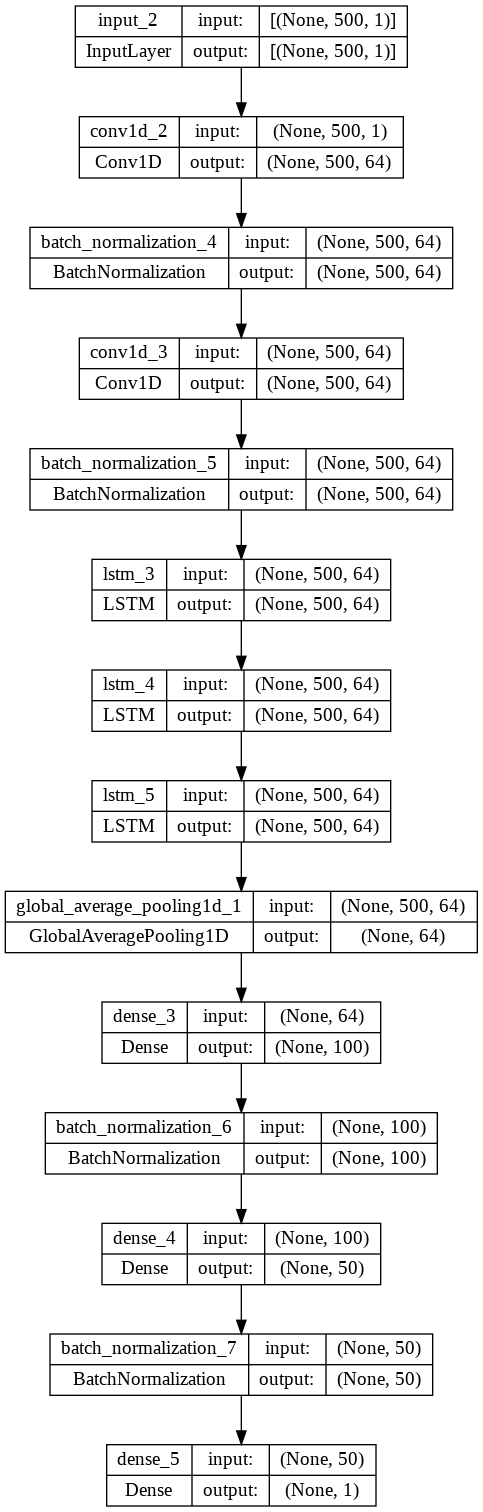

In [19]:
def make_model(input_shape):
    input_layer = tf.keras.layers.Input(input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding="same", activation='relu')(input_layer)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding="same", activation='relu')(conv1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)

    lstm1 = tf.keras.layers.LSTM(64, return_sequences=True)(conv2)
    lstm2 = tf.keras.layers.LSTM(64, return_sequences=True)(lstm1)
    lstm3 = tf.keras.layers.LSTM(64, return_sequences=True)(lstm2)

    gap = tf.keras.layers.GlobalAveragePooling1D()(lstm3)
    
    d1 = tf.keras.layers.Dense(100)(gap)
    d1 = tf.keras.layers.BatchNormalization()(d1)
    
    d2 = tf.keras.layers.Dense(50, activation="relu")(d1)
    d2 = tf.keras.layers.BatchNormalization()(d2)

    output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(d2)

    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
tf.keras.utils.plot_model(model, show_shapes = True )

## Train the model

In [20]:
epochs = 5
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint( "best_model.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])


In [21]:
history = model.fit(
    x_train, y_train, batch_size=batch_size, epochs=5,
    callbacks=callbacks,validation_split=0.2,  verbose=1,
)

Epoch 1/5
90/90 [==============================] - 85s 880ms/step - loss: 0.4064 - accuracy: 0.7990 - val_loss: 0.6944 - val_accuracy: 0.5104
Epoch 2/5
90/90 [==============================] - 76s 842ms/step - loss: 0.3256 - accuracy: 0.8490 - val_loss: 0.7143 - val_accuracy: 0.5104
Epoch 3/5
90/90 [==============================] - 76s 843ms/step - loss: 0.2715 - accuracy: 0.8795 - val_loss: 0.9543 - val_accuracy: 0.5104
Epoch 4/5
90/90 [==============================] - 76s 843ms/step - loss: 0.2613 - accuracy: 0.8851 - val_loss: 0.7774 - val_accuracy: 0.5368
Epoch 5/5
90/90 [==============================] - 76s 846ms/step - loss: 0.2415 - accuracy: 0.9035 - val_loss: 0.8304 - val_accuracy: 0.5451


## Evaluate model on test data

In [22]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 10s 209ms/step - loss: 0.6936 - accuracy: 0.5159
Test accuracy 0.5159090757369995
Test loss 0.6936280727386475


# Conv2D For signal classification/prediction

### Fetus Monitor example
![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/fetus1.png)

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/mri1.png)

# ConvLSTM and Convolutional-LSTM
ConvLSTM layer is a Recurrent layer, just like the LSTM, but internal matrix multiplications are exchanged with convolution operations. As a result, the data that flows through the ConvLSTM cells keeps the input dimension (3D in our case) instead of being just a 1D vector with features.
![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/convlstm.png)
A different approach of a ConvLSTM is a Convolutional-LSTM model, in which the image passes through the convolutions layers and its result is a set flattened to a 1D array with the obtained features. When repeating this process to all images in the time set, the result is a set of features over time, and this is the LSTM layer input.
* from https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7

Good tutorials: 
* https://www.kaggle.com/code/ripcurl/convlstm-convolutional-lstm-network-tutorial/edit
* https://keras.io/examples/vision/conv_lstm/